# [2024/25 S1] EE4309 Lab Project Part 2
TAs: Joya Chen, Ziteng Gao

**Introduction:**

This is the second part of the project. We will implement a vision transformer, and see how it helps R-CNN modules to achieve object detection.

**Target:**

Successfully complete all the coding blanks that require your input. Make sure your work produces the correct output.

**Score:**

The submission deadline is 11:59 PM on Oct 3. Students who submit before 11:59 PM today will receive a bonus score.

**Reference:**

[1] Exploring Plain Vision Transformer Backbones
for Object Detection. https://arxiv.org/pdf/2203.16527

[2] Mask R-CNN. https://arxiv.org/abs/1703.06870

[3] Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks. https://arxiv.org/abs/1506.01497

## 1. Check the environment

### 1.1. Download the ee4309_ folder from Canvas.
### 1.2. Upload the files to the root directory of your Colab space.

In [1]:
import torch, torchvision
from torch import nn
print('torch', torch.__version__) # torch 2.4.1+cu121
print('torchvision', torchvision.__version__) # 0.19.1+cu121

torch 2.4.1+cu121
torchvision 0.19.1+cu121


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install timm

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-9vvhfivs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-9vvhfivs
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 69.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

## 2. Load the image and display

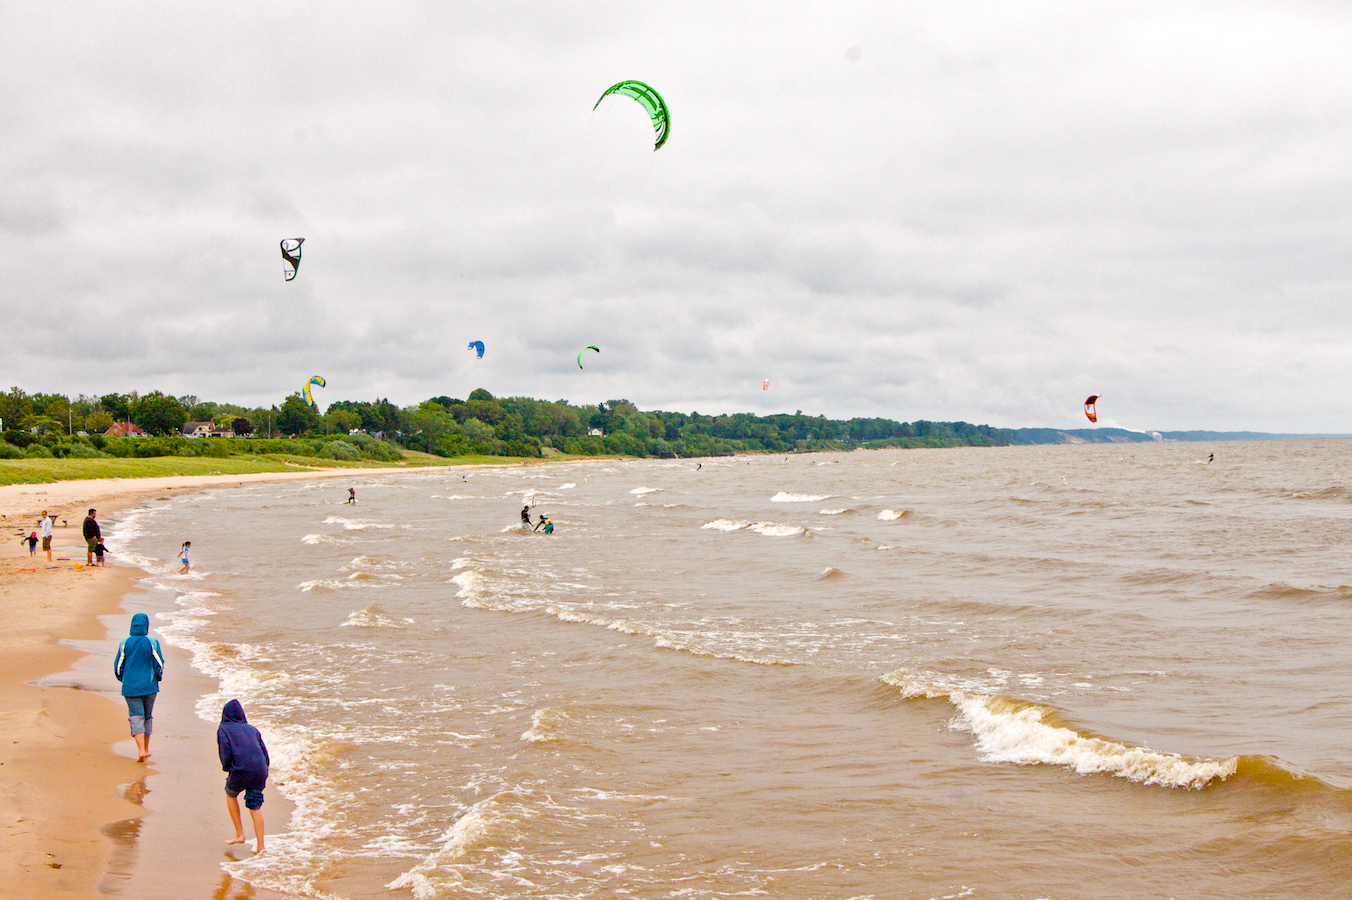

In [4]:
from detectron2.data.detection_utils import read_image
from PIL import Image
import numpy as np
### TODO: Please use PIL.Image to open image, and convert it to numpy

### === Start your coding ===
image_path = '/content/demo.jpg'  # Replace with your image path
image = Image.open(image_path)
image = np.array(image)

### === End your coding ===
display(Image.fromarray(image))

## 3. Preprocess the image

In [5]:
import torch
import numpy as np

# Given pixel_mean and pixel_std
pixel_mean = torch.tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

### === Start your coding ===

normed_image =torch.from_numpy(image).permute(2,0,1).float()/255.0
normed_image=(normed_image-pixel_mean)/pixel_std

### === End your coding ===

## 4. Patchify the image

In [6]:
from torch import nn
import torch

class PatchEmbed(nn.Module):
    def __init__(self):
        super().__init__()
        ### TODO: Please define a torch.nn.Conv2d layer, patchify the input image: every 16x16 non-overlap patch -> 768 channels
        ### === Start your coding ===
        self.proj = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=16, stride=16)
        ### === End your coding ===

    def forward(self, x):
        x = self.proj(x)  # Apply convolution to patchify the image
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x

# Test the module
test_module = PatchEmbed()

# Use inference mode to disable gradient calculation
with torch.inference_mode():
    test_patches = test_module(normed_image[None])  # Adding batch dimension with [None]

# Output patch size and perform assertions
print('Patches size', test_patches.shape)
assert test_patches.shape[1] == 56, 'Shape check failed. Please check your code...'
assert test_patches.shape[2] == 84, 'Shape check failed. Please check your code...'


Patches size torch.Size([1, 56, 84, 768])


## 5. Construct the attention module

In [7]:
import torch
from torch import nn
import torch.nn.functional as F

def get_rel_pos(q_size, k_size, rel_pos):
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]

def add_decomposed_rel_pos(attn, q, rel_pos_h, rel_pos_w, q_size, k_size):
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn

class Attention(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=True,
        input_size=None,
    ):
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool:  If True, add a learnable bias to query, key, value.
            input_size (int or None): Input resolution for calculating the relative positional
                parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        # initialize relative positional embeddings
        self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
        self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x):
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        ### TODO: Please implement the attention matrix computation
        ### === Start your coding ===
        # Compute scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale  # Shape: (B * nHead, N, N)
        
        # Apply softmax to get attention probabilities
        attn = attn.softmax(dim=-1)  # Shape: (B * nHead, N, N)
        ### === End your coding ===

        # Add decomposed relative positional embeddings
        attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        ### TODO: Please implement the attention softmax, multiply value, permute and reshape to correct shape, and do the final self.proj
        ### === Start your coding ===
        
        x=(attn@v).transpose(1,2).reshape(B,H,W,-1)
        x= self.proj(x)
        ### === End your coding ===

        return x

# Test the module
test_module = Attention(768, input_size=(14, 14))

# Test with inference mode
with torch.inference_mode():
    test_attn = test_module(test_patches)

# Output the results
print('Self-attention does not change the shape', test_patches.shape, test_attn.shape)


Self-attention does not change the shape torch.Size([1, 56, 84, 768]) torch.Size([1, 56, 84, 768])


## 6. Build a transformer block module

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

def window_partition(x, window_size):
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)

def window_unpartition(windows, window_size, pad_hw, hw):
    """
    Window unpartition into original sequences and removing padding.
    Args:
        x (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.

    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x

class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=True,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        act_layer=nn.GELU,
        window_size=0,
        input_size=None,
    ):
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            drop_path (float): Stochastic depth rate.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            input_size (int or None): Input resolution for calculating the relative positional
                parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            input_size=input_size if window_size == 0 else (window_size, window_size),
        )

        from timm.models.layers import Mlp

        self.norm2 = norm_layer(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer)

        self.window_size = window_size

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x
        ### TODO: Please finish the mlp part: x + (x -> norm2 -> mlp)
        ### === Start your coding ===
        shortcut = x
        x = x + self.mlp(self.norm2(x))
        ### === End your coding ===
        return x


test_module = Block(768, num_heads=12, window_size=14, input_size=(normed_image.shape[-2], normed_image.shape[-1]))
print(test_module)
with torch.inference_mode():
    test_block = test_module(test_patches)
print('Transformer block does not change the shape', test_patches.shape, test_block.shape)

Block(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): Attention(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
)
Transformer block does not change the shape torch.Size([1, 56, 84, 768]) torch.Size([1, 56, 84, 768])


## 7. With the transformer block (contains attention & Mlp), we use the block to stack a full vision transformer

In [10]:
from functools import partial
import math
from dataclasses import dataclass
from typing import Optional


@dataclass
class ShapeSpec:
    """
    A simple structure that contains basic shape specification about a tensor.
    It is often used as the auxiliary inputs/outputs of models,
    to complement the lack of shape inference ability among pytorch modules.
    """

    channels: Optional[int] = None
    height: Optional[int] = None
    width: Optional[int] = None
    stride: Optional[int] = None

def get_abs_pos(abs_pos, hw):
    """
    Calculate absolute positional embeddings. If needed, resize embeddings and remove cls_token
        dimension for the original embeddings.
    Args:
        abs_pos (Tensor): absolute positional embeddings with (1, num_position, C).
        has_cls_token (bool): If true, has 1 embedding in abs_pos for cls token.
        hw (Tuple): size of input image tokens.

    Returns:
        Absolute positional embeddings after processing with shape (1, H, W, C)
    """
    h, w = hw
    abs_pos = abs_pos[:, 1:]
    xy_num = abs_pos.shape[1]
    size = int(math.sqrt(xy_num))
    assert size * size == xy_num

    if size != h or size != w:
        new_abs_pos = F.interpolate(
            abs_pos.reshape(1, size, size, -1).permute(0, 3, 1, 2),
            size=(h, w),
            mode="bicubic",
            align_corners=False,
        )

        return new_abs_pos.permute(0, 2, 3, 1)
    else:
        return abs_pos.reshape(1, h, w, -1)

class ViT(nn.Module):
    """
    This module implements Vision Transformer (ViT) backbone in :paper:`vitdet`.
    "Exploring Plain Vision Transformer Backbones for Object Detection",
    https://arxiv.org/abs/2203.16527
    """

    def __init__(
        self,
        img_size=1024,
        patch_size=16,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        norm_layer=nn.LayerNorm,
        act_layer=nn.GELU,
        window_size=0,
        window_block_indexes=(),
        pretrain_img_size=224,
        out_feature="last_feat",
    ):
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            window_block_indexes (list): Indexes for blocks using window attention.
            use_act_checkpoint (bool): If True, use activation checkpointing.
            pretrain_img_size (int): input image size for pretraining models.
            out_feature (str): name of the feature from the last block.
        """
        super().__init__()

        self.patch_embed = PatchEmbed()

        num_patches = (pretrain_img_size // patch_size) * (pretrain_img_size // patch_size)
        num_positions = num_patches + 1
        self.pos_embed = nn.Parameter(torch.zeros(1, num_positions, embed_dim))

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                window_size=window_size if i in window_block_indexes else 0,
                input_size=(img_size // patch_size, img_size // patch_size),
            )
            self.blocks.append(block)

        self._out_feature_channels = {out_feature: embed_dim}
        self._out_feature_strides = {out_feature: patch_size}
        self._out_features = [out_feature]

    def forward(self, x):
        ### TODO: Please implement the full process of ViT: patch_embed -> + posiitonal encoding -> every block input & output
        ### === Start your coding ===
        x = self.patch_embed(x)
        x = x + get_abs_pos(self.pos_embed, (x.shape[1], x.shape[2]))
        for block in self.blocks:
            x = block(x)
        ### === End your coding ===
        outputs = {self._out_features[0]: x.permute(0, 3, 1, 2)}
        return outputs

    def output_shape(self):
        """
        Returns:
            dict[str->ShapeSpec]
        """
        # this is a backward-compatible default
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

vit = ViT(embed_dim=768, depth=12, num_heads=12, window_size=14, norm_layer=partial(nn.LayerNorm, eps=1e-6),
    window_block_indexes=[
        # 2, 5, 8 11 for global attention
        0,
        1,
        3,
        4,
        6,
        7,
        9,
        10,
    ],
    out_feature="last_feat",
)
vit.eval()
with torch.inference_mode():
    test_vit = vit(normed_image[None])
print('The output shape in BCHW', test_vit['last_feat'].shape)

The output shape in BCHW torch.Size([1, 768, 56, 84])


## 8. Construct Feature Pyramid Levels (This part does not need to code. Just simply run)

In [11]:
class Conv2d(torch.nn.Conv2d):
    """
    A wrapper around :class:`torch.nn.Conv2d` to support empty inputs and more features.
    """

    def __init__(self, *args, **kwargs):
        """
        Extra keyword arguments supported in addition to those in `torch.nn.Conv2d`:

        Args:
            norm (nn.Module, optional): a normalization layer
            activation (callable(Tensor) -> Tensor): a callable activation function

        It assumes that norm layer is used before activation.
        """
        norm = kwargs.pop("norm", None)
        activation = kwargs.pop("activation", None)
        super().__init__(*args, **kwargs)

        self.norm = norm
        self.activation = activation

    def forward(self, x):
        x = F.conv2d(
            x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        if self.norm is not None:
            x = self.norm(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

class LayerNorm(nn.Module):
    """
    A LayerNorm variant, popularized by Transformers, that performs point-wise mean and
    variance normalization over the channel dimension for inputs that have shape
    (batch_size, channels, height, width).
    https://github.com/facebookresearch/ConvNeXt/blob/d1fa8f6fef0a165b27399986cc2bdacc92777e40/models/convnext.py#L119  # noqa B950
    """

    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

class SimpleFeaturePyramid(nn.Module):
    """
    This module implements SimpleFeaturePyramid in :paper:`vitdet`.
    It creates pyramid features built on top of the input feature map.
    """

    def __init__(
        self,
        net,
        in_feature,
        out_channels,
        scale_factors,
        top_block=None,
        norm="LN",
        square_pad=0,
    ):
        """
        Args:
            net (Backbone): module representing the subnetwork backbone.
                Must be a subclass of :class:`Backbone`.
            in_feature (str): names of the input feature maps coming
                from the net.
            out_channels (int): number of channels in the output feature maps.
            scale_factors (list[float]): list of scaling factors to upsample or downsample
                the input features for creating pyramid features.
            top_block (nn.Module or None): if provided, an extra operation will
                be performed on the output of the last (smallest resolution)
                pyramid output, and the result will extend the result list. The top_block
                further downsamples the feature map. It must have an attribute
                "num_levels", meaning the number of extra pyramid levels added by
                this block, and "in_feature", which is a string representing
                its input feature (e.g., p5).
            norm (str): the normalization to use.
            square_pad (int): If > 0, require input images to be padded to specific square size.
        """
        super(SimpleFeaturePyramid, self).__init__()

        self.scale_factors = scale_factors

        input_shapes = net.output_shape()
        strides = [int(input_shapes[in_feature].stride / scale) for scale in scale_factors]

        dim = input_shapes[in_feature].channels
        self.stages = []
        use_bias = norm == ""
        for idx, scale in enumerate(scale_factors):
            out_dim = dim
            if scale == 4.0:
                layers = [
                    nn.ConvTranspose2d(dim, dim // 2, kernel_size=2, stride=2),
                    LayerNorm(dim // 2),
                    nn.GELU(),
                    nn.ConvTranspose2d(dim // 2, dim // 4, kernel_size=2, stride=2),
                ]
                out_dim = dim // 4
            elif scale == 2.0:
                layers = [nn.ConvTranspose2d(dim, dim // 2, kernel_size=2, stride=2)]
                out_dim = dim // 2
            elif scale == 1.0:
                layers = []
            elif scale == 0.5:
                layers = [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                raise NotImplementedError(f"scale_factor={scale} is not supported yet.")

            layers.extend(
                [
                    Conv2d(
                        out_dim,
                        out_channels,
                        kernel_size=1,
                        bias=use_bias,
                        norm=LayerNorm(out_channels),
                    ),
                    Conv2d(
                        out_channels,
                        out_channels,
                        kernel_size=3,
                        padding=1,
                        bias=use_bias,
                        norm=LayerNorm(out_channels),
                    ),
                ]
            )
            layers = nn.Sequential(*layers)

            stage = int(math.log2(strides[idx]))
            self.add_module(f"simfp_{stage}", layers)
            self.stages.append(layers)

        self.net = net
        self.in_feature = in_feature
        self.top_block = top_block
        # Return feature names are "p<stage>", like ["p2", "p3", ..., "p6"]
        self._out_feature_strides = {"p{}".format(int(math.log2(s))): s for s in strides}
        # top block output feature maps.
        if self.top_block is not None:
            for s in range(stage, stage + self.top_block.num_levels):
                self._out_feature_strides["p{}".format(s + 1)] = 2 ** (s + 1)

        self._out_features = list(self._out_feature_strides.keys())
        self._out_feature_channels = {k: out_channels for k in self._out_features}
        self._size_divisibility = strides[-1]
        self._square_pad = square_pad

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.

        Returns:
            dict[str->Tensor]:
                mapping from feature map name to pyramid feature map tensor
                in high to low resolution order. Returned feature names follow the FPN
                convention: "p<stage>", where stage has stride = 2 ** stage e.g.,
                ["p2", "p3", ..., "p6"].
        """
        bottom_up_features = self.net(x)
        features = bottom_up_features[self.in_feature]
        results = []

        for stage in self.stages:
            results.append(stage(features))

        if self.top_block is not None:
            if self.top_block.in_feature in bottom_up_features:
                top_block_in_feature = bottom_up_features[self.top_block.in_feature]
            else:
                top_block_in_feature = results[self._out_features.index(self.top_block.in_feature)]
            results.extend(self.top_block(top_block_in_feature))
        assert len(self._out_features) == len(results)
        return {f: res for f, res in zip(self._out_features, results)}

class LastLevelMaxPool(nn.Module):
    """
    This module is used in the original FPN to generate a downsampled
    P6 feature from P5.
    """

    def __init__(self):
        super().__init__()
        self.num_levels = 1
        self.in_feature = "p5"

    def forward(self, x):
        return [F.max_pool2d(x, kernel_size=1, stride=2, padding=0)]

backbone = SimpleFeaturePyramid(
    net=ViT(embed_dim=768, depth=12, num_heads=12, window_size=14, norm_layer=partial(nn.LayerNorm, eps=1e-6),
        window_block_indexes=[
            # 2, 5, 8 11 for global attention
            0,
            1,
            3,
            4,
            6,
            7,
            9,
            10,
        ],
        out_feature="last_feat",
    ),
    in_feature="last_feat",
    out_channels=256,
    scale_factors=(4.0, 2.0, 1.0, 0.5),
    top_block=LastLevelMaxPool(),
    norm="LN",
    square_pad=1024,
)
print(backbone)

SimpleFeaturePyramid(
  (simfp_2): Sequential(
    (0): ConvTranspose2d(768, 384, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm()
    (2): GELU(approximate='none')
    (3): ConvTranspose2d(384, 192, kernel_size=(2, 2), stride=(2, 2))
    (4): Conv2d(
      192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): LayerNorm()
    )
    (5): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): LayerNorm()
    )
  )
  (simfp_3): Sequential(
    (0): ConvTranspose2d(768, 384, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(
      384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): LayerNorm()
    )
    (2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): LayerNorm()
    )
  )
  (simfp_4): Sequential(
    (0): Conv2d(
      768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): LayerNorm()
    )
    (1): Conv2d(
      256, 256, kernel_siz

In [12]:
backbone.load_state_dict(torch.load('vit_backbone.pt'))

<ipython-input-12-d8224562fe32>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone.load_state_dict(torch.load('vit_backbone.pt'))


<All keys matched successfully>

## 9. Now, we have built ViT + Feature Pyramid. This is a strong backbone for rich image feature representation, which can greatly support the following R-CNN-style detection modules. In part 1, we have learned RPN & R-CNN heads. They are same as that for ViT Faster R-CNN. So, let's skip them, but just use our implemented ViT as backbone to achieve object detection. (This part does not need to code. Just simply run)

In [13]:
import os
from detectron2.config import LazyConfig, instantiate
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

config_file = 'vitdet-b_inference.py'
cfg = LazyConfig.load(config_file)
model = instantiate(cfg.model)
!wget https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/mask_rcnn_vitdet_b/f325346929/model_final_61ccd1.pkl
DetectionCheckpointer(model).load('model_final_61ccd1.pkl')

--2024-10-01 10:20:31--  https://dl.fbaipublicfiles.com/detectron2/ViTDet/COCO/mask_rcnn_vitdet_b/f325346929/model_final_61ccd1.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443614688 (423M) [binary/octet-stream]
Saving to: ‘model_final_61ccd1.pkl’

model_final_61ccd1. 100%[===================>] 423.06M   263MB/s    in 1.6s    

2024-10-01 10:20:33 (263 MB/s) - ‘model_final_61ccd1.pkl’ saved [443614688/443614688]



{'__author__': 'Detectron2 ViTDet Model Zoo'}

In [14]:
import torch
model.eval()
with torch.inference_mode():
    inputs = {"image": torch.as_tensor(image.astype("float32").transpose(2, 0, 1)), "height": normed_image.shape[-2], "width": normed_image.shape[-1]}
    batched_inputs = [inputs]
    images = model.preprocess_image(batched_inputs)
    features = model.backbone(images.tensor) # Let's use our backbone
    # features = backbone(normed_image[None])
    proposals, _ = model.proposal_generator(images, features, None)
    results, _ = model.roi_heads(images, features, proposals, None)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


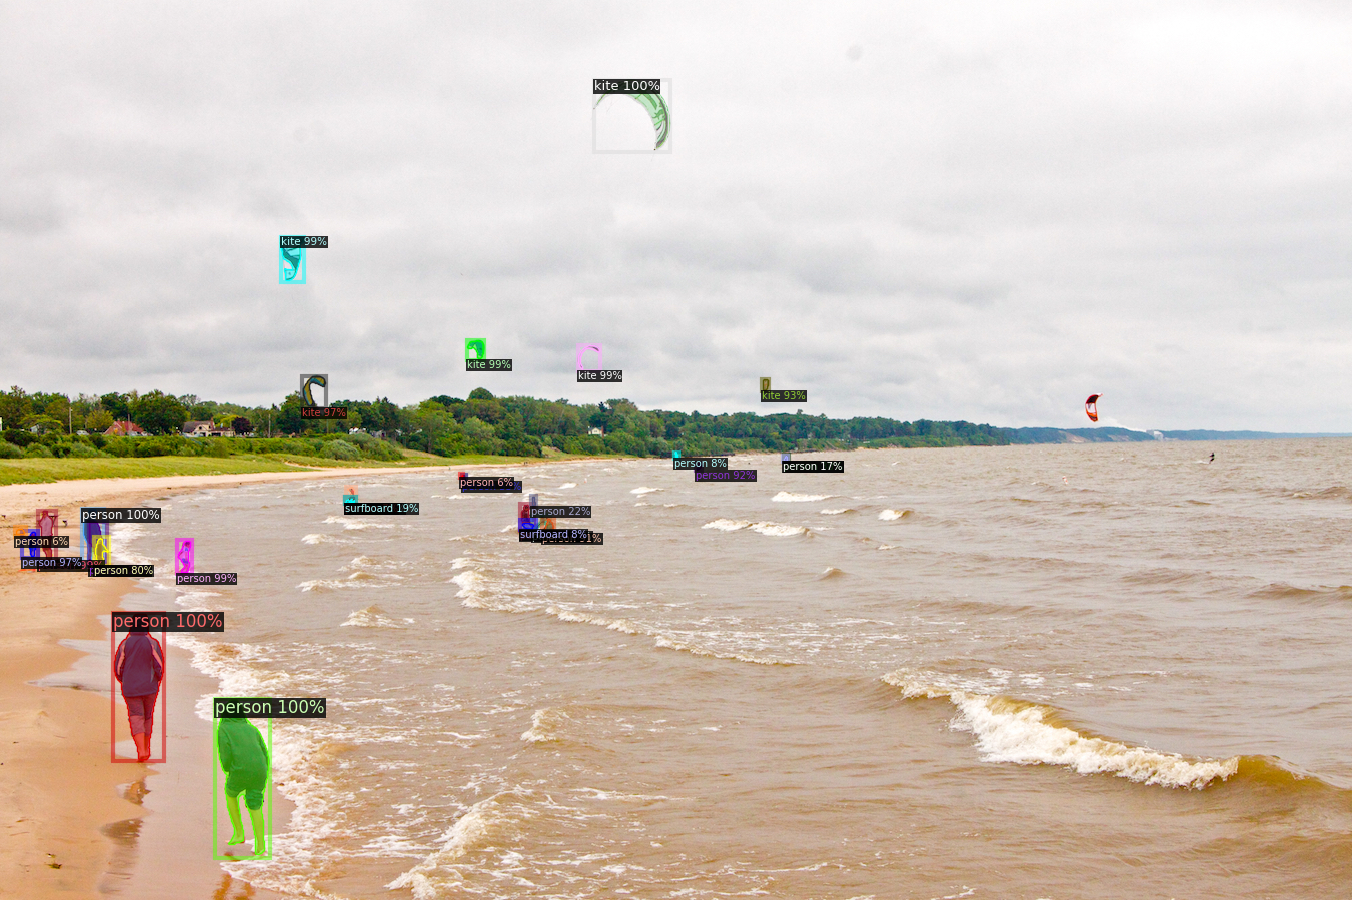

In [15]:
import detectron2.data.transforms as T
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.modeling import GeneralizedRCNN
from detectron2.data import MetadataCatalog

with torch.inference_mode():
    predictions = GeneralizedRCNN._postprocess(results, batched_inputs, images.image_sizes)[0]['instances']

metadata = MetadataCatalog.get('coco_2017_train')
visualizer = Visualizer(image, metadata, instance_mode=ColorMode.IMAGE)
vis_output = visualizer.draw_instance_predictions(predictions=predictions)
display(Image.fromarray(vis_output.get_image()))